# Failure Classification Modeling

This notebook aims to show the modeling step for predicting the failure class

In [61]:
import os
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_regression

# ignore warnings
warnings.filterwarnings('ignore')

# definition of constants
DATASOURCE = '../../data/3_model_data'
MODELS = '../../models'
DATANAME = 'train_classification.csv'

In [62]:
# load data
data = pd.read_csv(os.path.join(DATASOURCE, DATANAME))
data.head()

,runtime,tag2,tag3,tag4,tag7,tag9,tag11,tag12,tag14,tag15,tag17,tag20,tag21,categ
0,1,641.82,1589.70,1400.60,554.36,9046.19,47.47,521.66,8138.62,8.4195,392,39.06,23.4190,0
1,2,642.15,1591.82,1403.14,553.75,9044.07,47.49,522.28,8131.49,8.4318,392,39.00,23.4236,0
2,3,642.35,1587.99,1404.20,554.26,9052.94,47.27,522.42,8133.23,8.4178,390,38.95,23.3442,0
3,4,642.35,1582.79,1401.87,554.45,9049.48,47.13,522.86,8133.83,8.3682,392,38.88,23.3739,0
4,5,642.37,1582.85,1406.22,554.00,9055.15,47.28,522.19,8133.80,8.4294,393,38.90,23.4044,0


In [63]:
# split into predictors and predicted
x = data.drop(['categ'], axis=1)
y = data[['categ']]

In [78]:
x.describe()

,runtime,tag2,tag3,tag4,tag7,tag9,tag11,tag12,tag14,tag15,tag17,tag20,tag21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,108.807862,642.680934,1590.523119,1408.933782,553.367711,9065.242941,47.541168,521.413470,8143.752722,8.442146,393.210654,38.816271,23.289705
std,68.880990,0.500053,6.131150,9.000605,0.885092,22.082880,0.267087,0.737553,19.076176,0.037505,1.548763,0.180746,0.108251
min,1.000000,641.210000,1571.040000,1382.250000,549.850000,9021.730000,46.850000,518.690000,8099.940000,8.324900,388.000000,38.140000,22.894200
25%,52.000000,642.325000,1586.260000,1402.360000,552.810000,9053.100000,47.350000,520.960000,8133.245000,8.414900,392.000000,38.700000,23.221800
50%,104.000000,642.640000,1590.100000,1408.040000,553.440000,9060.660000,47.510000,521.480000,8140.540000,8.438900,393.000000,38.830000,23.297900
75%,156.000000,643.000000,1594.380000,1414.555000,554.010000,9069.420000,47.700000,521.950000,8148.310000,8.465600,394.000000,38.950000,23.366800
max,362.000000,644.530000,1616.910000,1441.490000,556.060000,9244.590000,48.530000,523.380000,8293.720000,8.584800,400.000000,39.430000,23.618400


In [64]:
# configure cross validation object
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)

## Linear Model Approach

In [65]:
# configure model pipeline and parameters search space
linear_model_pipeline = Pipeline([
    ('feature_selector_1', SelectKBest(f_regression)),
    ('scaler', RobustScaler()),
    ('feature_selector_2', SelectFromModel(LogisticRegression(penalty='l1', random_state=2, solver='saga'))),
    ('linear_model', LogisticRegression(penalty='l2', random_state=2, solver='saga'))
])

model_params = {
    'feature_selector_1__k': range(1, 8),
    'feature_selector_2__estimator__C': np.random.uniform(0.001, 20, 1000),
    'linear_model__C': np.random.uniform(0.001, 20, 1000)
}

In [66]:
# create object to search hyperparameters
linear_search = RandomizedSearchCV(
    estimator=linear_model_pipeline,
    param_distributions=model_params,
    n_iter=50,
    scoring='f1',
    refit=True,
    cv=kfold
)

# ajuste do modelo
linear_search.fit(x, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('feature_selector_1',
                                              SelectKBest(score_func=<function f_regression at 0x0000027B6CE80310>)),
                                             ('scaler', RobustScaler()),
                                             ('feature_selector_2',
                                              SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                           random_state=2,
                                                                                           solver='saga'))),
                                             ('linear_model',
                                              Lo...
       15.35389794,  8.81374103,  0.60712119,  1.98027505, 13.31580869,
       11.3995405 ,  2.56985963, 14.23048494, 15.18324349, 12.47943114,
       12.10692205,  2.41847739,  2.97356722, 15.54184819,  9.2942213 ,
        5.24381847, 15.5954066 ,  5.00118259, 11.56883343, 18.65665091,
       10.65258642,  0.68319098, 16.92104657,  3.10236849, 12.33264413,
       19.27282187,  8.23234533, 19.64314752,  3.75584424,  4.87357964])},
                   scoring='f1')

In [67]:
print('Best Combination of Parameters:')
print(linear_search.best_params_)

Best Combination of Parameters:
{'linear_model__C': 5.4834341579064265, 'feature_selector_2__estimator__C': 5.814610803961091, 'feature_selector_1__k': 7}


In [68]:
print('Best Average Score:')
print(linear_search.best_score_)

Best Average Score:
0.8178398878937142


In [69]:
# lets analyse the metrics in the full dataset
linear_model = linear_search.best_estimator_

# make predictions
yhat_linear = linear_model.predict(x)

print('Recall Score: ', recall_score(y, yhat_linear))
print('F1 Score: ', f1_score(y, yhat_linear))

Recall Score:  0.7776
F1 Score:  0.8178376104333194


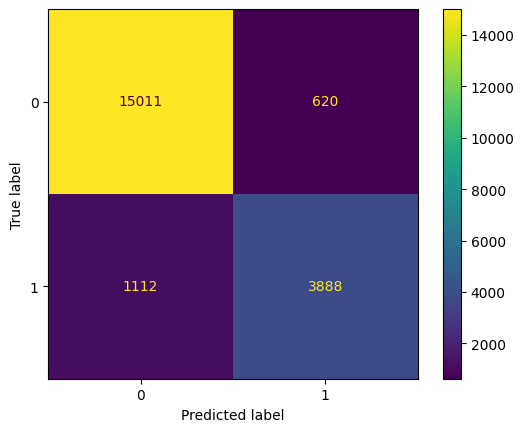

In [70]:
# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y, yhat_linear)

## Non Linear Model Approach

In [71]:
# configure model pipeline and parameters search space
nlinear_model_pipeline = Pipeline([
    ('feature_selector_1', SelectKBest(f_regression)),
    ('scaler', RobustScaler()),
    ('feature_selector_2', SelectFromModel(LogisticRegression(penalty='l1', random_state=2, solver='saga'))),
    ('nlinear_model', GradientBoostingClassifier(random_state=2))
])

model_params = {
    'feature_selector_1__k': range(1, 8),
    'feature_selector_2__estimator__C': np.random.uniform(0.001, 20, 200),
    'nlinear_model__n_estimators': np.random.randint(50, 1000, 200),
    'nlinear_model__learning_rate': np.random.uniform(0.01, 0.9, 200),
    'nlinear_model__max_depth': range(1, 17),
}

In [72]:
# create object to search hyperparameters
nlinear_search = RandomizedSearchCV(
    estimator=nlinear_model_pipeline,
    param_distributions=model_params,
    n_iter=5,
    scoring='f1',
    refit=True,
    cv=kfold
)

# ajuste do modelo
nlinear_search.fit(x, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('feature_selector_1',
                                              SelectKBest(score_func=<function f_regression at 0x0000027B6CE80310>)),
                                             ('scaler', RobustScaler()),
                                             ('feature_selector_2',
                                              SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                           random_state=2,
                                                                                           solver='saga'))),
                                             ('nlinear_model',
                                              G...
       751, 804, 558, 127, 825, 528, 612, 759, 192, 360, 373, 796,  66,
       290, 415, 676,  87, 367, 424, 916, 450, 285, 390, 586, 609, 751,
       417, 194, 716, 386, 668, 489, 548,  64, 166, 526, 824, 244, 204,
       241, 383, 561, 634, 546, 331, 179, 976, 157, 505, 289, 396, 365,
       856, 499, 683, 561,  50, 454, 219,  69, 610, 609, 761, 119, 852,
       155, 391, 381, 966, 255, 881, 657, 333, 769, 695, 989, 157, 715,
       790,  83, 306, 283, 926, 296, 612,  80, 357, 355,  77, 865, 713,
       686, 309, 449, 708, 657])},
                   scoring='f1')

In [73]:
print('Best Combination of Parameters:')
print(nlinear_search.best_params_)

Best Combination of Parameters:
{'nlinear_model__n_estimators': 237, 'nlinear_model__max_depth': 3, 'nlinear_model__learning_rate': 0.38107440024559514, 'feature_selector_2__estimator__C': 8.792093914498523, 'feature_selector_1__k': 4}


In [74]:
print('Best Average Score:')
print(nlinear_search.best_score_)

Best Average Score:
0.7855528549672285


In [75]:
# lets analyse the metrics in the full dataset
nlinear_model = nlinear_search.best_estimator_

# make predictions
yhat_nlinear = nlinear_model.predict(x)

print('Recall Score: ', recall_score(y, yhat_nlinear))
print('F1 Score: ', f1_score(y, yhat_nlinear))

Recall Score:  0.8288
F1 Score:  0.8769442387048989


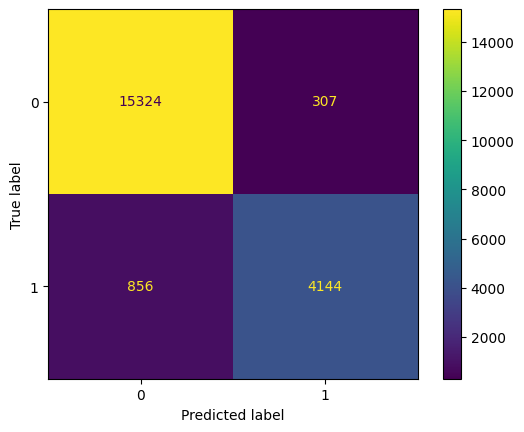

In [76]:
# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y, yhat_nlinear)

In [77]:
# save model
if not os.path.isdir(MODELS):
    os.makedirs(MODELS)

joblib.dump(linear_model, os.path.join(MODELS, 'classification_model.m'))

['../../models\\classification_model.m']